In [ ]:
!mkdir datasets

In [5]:
!mkdir datasets/CIFAR10

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from tqdm import tqdm

In [2]:
torch.random.manual_seed(42)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_path = './datasets/CIFAR10'

/home/nikolay/Documents/Environments/r2g_shutter/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cpu')

In [5]:
class Bluring:
    def __init__(self, kernel, padding=0, stride=1 ):
        assert len(kernel.shape) == 2
        self.kernel = kernel
        self.v_pad = int(np.ceil((kernel.shape[1] - 1)/2))
        self.h_pad = int(np.ceil((kernel.shape[0] - 1)/2))
        self.padding = int(max(self.v_pad, self.h_pad))
        self.stride = 1
        
    def __call__(self, sample):
        #image, landmark = sample[0], sample[1]
        channels = sample.shape[-3]

        #Constructing filters for conv2d
        k_array = []
        for k in range(channels):
            kernel = (*(torch.zeros_like(self.kernel),)*k,
                      self.kernel,
                      *(torch.zeros_like(self.kernel),)*(channels-k-1))
            k_array.append(torch.stack(kernel, dim=0))
        kernels = torch.stack((*k_array,), dim=0).to(device)
        
        #conv2d
        #print(sample.shape)
        if len(sample.shape) < 4:
            sample = sample[None,:]
            
        #print(sample.shape)
        res = torch.nn.functional.conv2d(sample, kernels, padding=self.padding, stride=self.stride)

        #cutting
        res = self.cutting(res)
        
        #reducing dimension
        res = torch.unbind(res)[0]
        
        #dummy normalization
        pixel_ones = torch.ones(sample.shape[-3],sample.shape[-2],sample.shape[-1]).to(device)
        #pixel_ones = torch.ones_like(sample)
        sum_pixels = torch.nn.functional.conv2d(pixel_ones[None,:], kernels, padding=self.padding, stride=self.stride)
        sum_pixels = self.cutting(sum_pixels)
        norm_matrix = torch.pow(sum_pixels,-1)
        norm_res = torch.mul(res, norm_matrix)
        
        #reducing dimension
        norm_res = torch.unbind(norm_res)[0]
        
        return (norm_res)
    
    
    def cutting(self, img):
        if self.v_pad < self.h_pad:
            cat = int(self.h_pad - self.v_pad)
            img = img[:,:,:,cat:-cat]
        elif self.h_pad < self.v_pad:
            cat = int(self.v_pad - self.h_pad)
            img = img[:,:,cat:-cat,:]
            
        #additional horizontal catting (not or right)    
        if kernel.shape[0] % 2 ==0:
            img = img[:,:,:-1,:]
            
        #additional vertical catting (not or right)    
        if kernel.shape[1] % 2 ==0:
            img = img[:,:,:,:-1]
        return img
        

In [7]:
batch_size = 64
kernel = torch.Tensor([[1]])
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #Bluring(kernel)
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])    

train_set = torchvision.datasets.CIFAR10(data_path, train=True, download=True, transform=train_transform )
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=3)

test_set = torchvision.datasets.CIFAR10(data_path, train=False, download=True, transform=test_transform )
test_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=3)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print('Train size', len(train_set))
print('Test size', len(test_set))

Files already downloaded and verified
Files already downloaded and verified
Train size 50000
Test size 10000


In [8]:
def check_blur(loader,ind, bluring):
    num = 2
    size = 6
    dataset = loader.dataset
    fig, ax = plt.subplots(num,2,figsize=(num*size/2,size))
    for i in range (num):
        ax[i][0].axis('off')
        ax[i][1].axis('off')
        
        img = dataset[ind+i][0][:,:,:]
        blur_img = bluring(img.to(device)).cpu()
        title_img = str('original ' + classes[dataset[ind+i][1]] + 'shape ' + str(img.shape))
        title_blur_img = str('blured ' + classes[dataset[ind+i][1]] + 'shape ' + str(blur_img.shape))
        ax[i][0].set_title(title_img, fontsize = 8)
        ax[i][1].set_title(title_blur_img, fontsize = 8)

        ax[i][0].imshow(img.permute(1,2,0))
        ax[i][1].imshow(blur_img.permute(1,2,0))

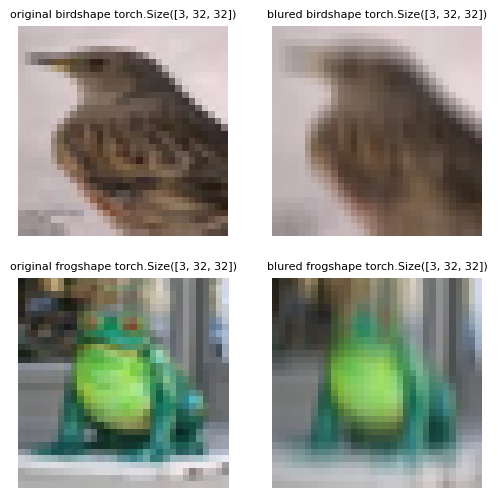

In [9]:
kernel = torch.Tensor([[1],
                       [1],
                       [1],
                       [1],
                       [1],
                      ])
blur_func = Bluring(kernel)
ind = 18

check_blur(train_loader, ind, blur_func)

In [75]:
class FC_Net(nn.Module):
    def __init__(self, shape):
        #super(FC_Net, self).__init__()
        super().__init__()
        self.shape = shape
        self.fc = nn.Linear(shape.numel(),shape.numel(), bias=False)
        #self.flat = nn.Flatten()
        
    def forward(self,x):
        #x = self.flat(x)
        x = x.view(-1,self.shape.numel())
        #print(x.shape)
        out = self.fc(x).view(-1, *self.shape)  
        return out

In [21]:
def epoch_train(loader, clf, criterion, opt, blur_func):
    # BEGIN Solution (do not delete this comment!)
    clf.train(True)
    all_loss = np.array([])
    
    for target, _ in loader:
        target = target.to(device)
        model_input = blur_func(target).to(device)
        #model_input = target.to(device)

        model_output = clf(model_input)
        loss = criterion(model_output,target)

        all_loss = np.append(all_loss, loss.cpu().detach().numpy())
        
        opt.zero_grad()
        loss.backward()
        opt.step()
    return all_loss.mean()

    # END Solution (do not delete this comment!)

def epoch_test(loader, clf, criterion, blur_func):
    # BEGIN Solution (do not delete this comment!)
    clf.eval()
    all_loss = np.array([])
    
    for target, _ in loader:
        with torch.no_grad():
            target = target.to(device)
            model_input = blur_func(target)

            model_output = clf(model_input)
            loss = criterion(model_output,target)

            all_loss = np.append(all_loss, loss.cpu().detach().numpy())
    return all_loss.mean()
    # END Solution (do not delete this comment!)

# The function which you are going to use for model training
def train(train_loader, test_loader, clf, criterion, opt, blur_func,n_epochs=50):
    for epoch in tqdm(range(n_epochs)):
        train_loss = epoch_train(train_loader, clf, criterion, opt, blur_func)
        test_loss = epoch_test(test_loader, clf, criterion, blur_func)
        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f};' + 
              f'test loss: {test_loss:.3f};')

In [76]:
img = train_loader.dataset[0][0]
blured = blur_func(img)
criterion(img, blured)

tensor(0.0016)

In [29]:
model.parameters

<bound method Module.parameters of FC_Net(
  (fc): Linear(in_features=3072, out_features=3072, bias=True)
)>

In [77]:
model = FC_Net(train_loader.dataset[0][0].shape).to(device)
lr = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

kernel = torch.Tensor([[1,1,1]]).to(device)
blur_func = Bluring(kernel)

In [78]:
lr = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [79]:
train(train_loader, test_loader, model, criterion, optimizer,blur_func, n_epochs=50)

  0%|                                                    | 0/50 [00:00<?, ?it/s]/home/nikolay/Documents/Environments/r2g_shutter/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 3, 32, 32])) that is different to the input size (torch.Size([1, 3, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/nikolay/Documents/Environments/r2g_shutter/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([16, 3, 32, 32])) that is different to the input size (torch.Size([1, 3, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  2%|▉                                           | 1/50 [00:25<20:27, 25.05s/it]

[Epoch 1] train loss: 0.129;test loss: 0.089;


  4%|█▊                                          | 2/50 [00:50<20:13, 25.27s/it]

[Epoch 2] train loss: 0.088;test loss: 0.088;


  6%|██▋                                         | 3/50 [01:15<19:51, 25.36s/it]

[Epoch 3] train loss: 0.087;test loss: 0.087;


  8%|███▌                                        | 4/50 [01:41<19:22, 25.28s/it]

[Epoch 4] train loss: 0.087;test loss: 0.087;


 10%|████▍                                       | 5/50 [02:06<19:03, 25.42s/it]

[Epoch 5] train loss: 0.085;test loss: 0.085;


 12%|█████▎                                      | 6/50 [02:32<18:43, 25.53s/it]

[Epoch 6] train loss: 0.083;test loss: 0.084;


 14%|██████▏                                     | 7/50 [02:57<18:15, 25.48s/it]

[Epoch 7] train loss: 0.083;test loss: 0.083;


 16%|███████                                     | 8/50 [03:24<18:00, 25.73s/it]

[Epoch 8] train loss: 0.082;test loss: 0.084;


 18%|███████▉                                    | 9/50 [03:50<17:45, 25.98s/it]

[Epoch 9] train loss: 0.083;test loss: 0.082;


 20%|████████▌                                  | 10/50 [04:17<17:33, 26.34s/it]

[Epoch 10] train loss: 0.082;test loss: 0.082;


 22%|█████████▍                                 | 11/50 [04:47<17:41, 27.21s/it]

[Epoch 11] train loss: 0.082;test loss: 0.082;


 24%|██████████▎                                | 12/50 [05:15<17:25, 27.50s/it]

[Epoch 12] train loss: 0.081;test loss: 0.082;


 26%|███████████▏                               | 13/50 [05:44<17:23, 28.20s/it]

[Epoch 13] train loss: 0.081;test loss: 0.081;


 28%|████████████                               | 14/50 [06:14<17:07, 28.53s/it]

[Epoch 14] train loss: 0.080;test loss: 0.080;


 30%|████████████▉                              | 15/50 [06:43<16:45, 28.73s/it]

[Epoch 15] train loss: 0.081;test loss: 0.080;


 32%|█████████████▊                             | 16/50 [07:12<16:20, 28.83s/it]

[Epoch 16] train loss: 0.080;test loss: 0.080;


 34%|██████████████▌                            | 17/50 [07:40<15:43, 28.58s/it]

[Epoch 17] train loss: 0.081;test loss: 0.080;


 36%|███████████████▍                           | 18/50 [08:07<15:00, 28.14s/it]

[Epoch 18] train loss: 0.079;test loss: 0.081;


 38%|████████████████▎                          | 19/50 [08:33<14:14, 27.56s/it]

[Epoch 19] train loss: 0.079;test loss: 0.080;


 40%|█████████████████▏                         | 20/50 [09:00<13:35, 27.18s/it]

[Epoch 20] train loss: 0.080;test loss: 0.079;


 42%|██████████████████                         | 21/50 [09:26<13:00, 26.91s/it]

[Epoch 21] train loss: 0.080;test loss: 0.080;


 44%|██████████████████▉                        | 22/50 [09:52<12:24, 26.60s/it]

[Epoch 22] train loss: 0.080;test loss: 0.079;


 46%|███████████████████▊                       | 23/50 [10:18<11:54, 26.46s/it]

[Epoch 23] train loss: 0.078;test loss: 0.078;


 48%|████████████████████▋                      | 24/50 [10:44<11:25, 26.38s/it]

[Epoch 24] train loss: 0.077;test loss: 0.078;


 50%|█████████████████████▌                     | 25/50 [11:10<10:57, 26.30s/it]

[Epoch 25] train loss: 0.079;test loss: 0.080;


 52%|██████████████████████▎                    | 26/50 [11:36<10:28, 26.21s/it]

[Epoch 26] train loss: 0.079;test loss: 0.078;


 54%|███████████████████████▏                   | 27/50 [12:02<10:02, 26.20s/it]

[Epoch 27] train loss: 0.079;test loss: 0.079;


 56%|████████████████████████                   | 28/50 [12:29<09:36, 26.22s/it]

[Epoch 28] train loss: 0.078;test loss: 0.078;


 58%|████████████████████████▉                  | 29/50 [12:55<09:10, 26.22s/it]

[Epoch 29] train loss: 0.078;test loss: 0.078;


 60%|█████████████████████████▊                 | 30/50 [13:21<08:45, 26.25s/it]

[Epoch 30] train loss: 0.078;test loss: 0.080;


 62%|██████████████████████████▋                | 31/50 [13:47<08:18, 26.21s/it]

[Epoch 31] train loss: 0.077;test loss: 0.077;


 64%|███████████████████████████▌               | 32/50 [14:14<07:52, 26.24s/it]

[Epoch 32] train loss: 0.078;test loss: 0.079;


 66%|████████████████████████████▍              | 33/50 [14:40<07:26, 26.25s/it]

[Epoch 33] train loss: 0.077;test loss: 0.077;


 68%|█████████████████████████████▏             | 34/50 [15:06<07:00, 26.25s/it]

[Epoch 34] train loss: 0.078;test loss: 0.078;


 70%|██████████████████████████████             | 35/50 [15:32<06:31, 26.11s/it]

[Epoch 35] train loss: 0.077;test loss: 0.078;


 72%|██████████████████████████████▉            | 36/50 [15:58<06:05, 26.11s/it]

[Epoch 36] train loss: 0.078;test loss: 0.078;


 74%|███████████████████████████████▊           | 37/50 [16:24<05:38, 26.07s/it]

[Epoch 37] train loss: 0.078;test loss: 0.077;


 76%|████████████████████████████████▋          | 38/50 [16:50<05:13, 26.14s/it]

[Epoch 38] train loss: 0.077;test loss: 0.077;


 78%|█████████████████████████████████▌         | 39/50 [17:17<04:48, 26.19s/it]

[Epoch 39] train loss: 0.077;test loss: 0.077;


 80%|██████████████████████████████████▍        | 40/50 [17:43<04:22, 26.24s/it]

[Epoch 40] train loss: 0.077;test loss: 0.077;


 82%|███████████████████████████████████▎       | 41/50 [18:09<03:55, 26.20s/it]

[Epoch 41] train loss: 0.077;test loss: 0.078;


 84%|████████████████████████████████████       | 42/50 [18:35<03:29, 26.24s/it]

[Epoch 42] train loss: 0.078;test loss: 0.077;


 86%|████████████████████████████████████▉      | 43/50 [19:01<03:03, 26.18s/it]

[Epoch 43] train loss: 0.077;test loss: 0.078;


 88%|█████████████████████████████████████▊     | 44/50 [19:28<02:37, 26.21s/it]

[Epoch 44] train loss: 0.078;test loss: 0.077;


 90%|██████████████████████████████████████▋    | 45/50 [19:54<02:10, 26.16s/it]

[Epoch 45] train loss: 0.077;test loss: 0.077;


 92%|███████████████████████████████████████▌   | 46/50 [20:20<01:44, 26.20s/it]

[Epoch 46] train loss: 0.078;test loss: 0.077;


 94%|████████████████████████████████████████▍  | 47/50 [20:47<01:18, 26.26s/it]

[Epoch 47] train loss: 0.077;test loss: 0.077;


 96%|█████████████████████████████████████████▎ | 48/50 [21:13<00:52, 26.30s/it]

[Epoch 48] train loss: 0.078;test loss: 0.076;


 98%|██████████████████████████████████████████▏| 49/50 [21:39<00:26, 26.32s/it]

[Epoch 49] train loss: 0.077;test loss: 0.077;


100%|███████████████████████████████████████████| 50/50 [22:06<00:00, 26.52s/it]

[Epoch 50] train loss: 0.077;test loss: 0.076;


In [32]:
def check_blur_clf(loader,ind, bluring, clf):
    num = 2
    size = 12
    dataset = loader.dataset
    fig, ax = plt.subplots(num,3,figsize=(num*size/2,size*0.5))
    for i in range (num):
        ax[i][0].axis('off')
        ax[i][1].axis('off')
        ax[i][2].axis('off')
        
        img = dataset[ind+i][0][:,:,:]
        blur_img = bluring(img.to(device))
        unblur_img = clf(blur_img).cpu().detach()
        unblur_img = unblur_img.view(*blur_img.shape)
        print(unblur_img.shape)
        title_img = str('original ' + classes[dataset[ind+i][1]] + 'shape ' + str(img.shape))
        title_blur_img = str('blured ' + classes[dataset[ind+i][1]] + 'shape ' + str(blur_img.shape))
        title_unblur_img = str('unblured ' + classes[dataset[ind+i][1]] + 'shape ' + str(unblur_img.shape))
        ax[i][0].set_title(title_img, fontsize = 8)
        ax[i][1].set_title(title_blur_img, fontsize = 8)
        ax[i][2].set_title(title_unblur_img, fontsize = 8)

        ax[i][0].imshow(img.permute(1,2,0))
        ax[i][1].imshow(blur_img.cpu().permute(1,2,0))
        ax[i][2].imshow(unblur_img.cpu().permute(1,2,0))

torch.Size([3, 32, 32])
torch.Size([3, 32, 32])


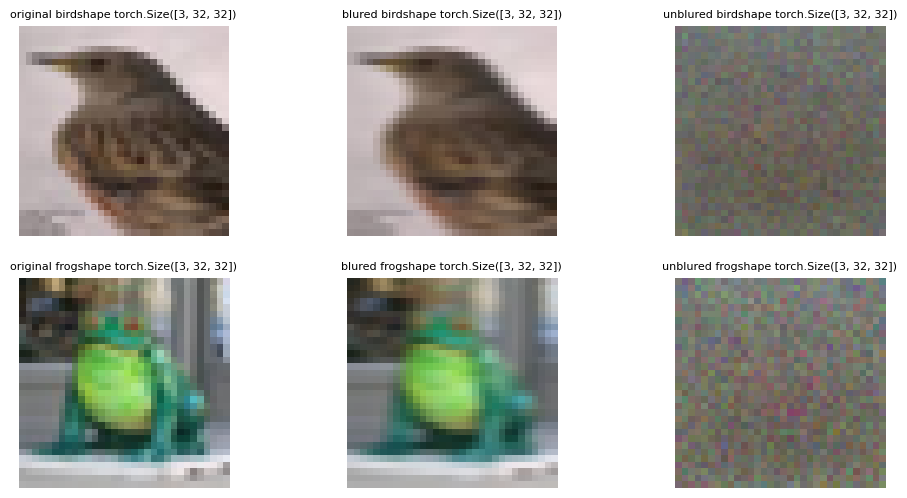

In [33]:
kernel = torch.Tensor([[1,1,1]])
blur_func = Bluring(kernel)
ind = 18

check_blur_clf(train_loader, ind, blur_func,model)

In [63]:
param = list(model.parameters())

In [74]:
type(param[0])

torch.nn.parameter.Parameter

In [73]:
new_paramtorch.eye(param[0].shape[0])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])